# UmojaHack Hackathon
---
Granular information on economic well-being is extremely useful for governments, policy makers, and NGOs. But household surveys that capture this kind of information are expensive and conducted infrequently in many African countries. For this competition we will attempt to create a workaround for this lack of data by building a model able to predict a measure of wealth as measured in household surveys using readily available inputs.

Using data from 18 different countries collected at different times, you must correctly predict the cluster-level estimated wealth measures found from surveys in 7 different countries not covered in the training data. A successful model could be useful for filling in the gaps between the more expensive surveys.

In [1]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.max_columns", 100, "display.max_rows", 22000)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
wealth = pd.read_csv("Train.csv")
wealthTest = pd.read_csv("Test.csv")
submission = pd.read_csv("SampleSubmission.csv")

wealth.head()

ID     country  year urban_or_rural  ghsl_water_surface  \
0  ID_AAIethGy    Ethiopia  2016              R                 0.0   
1  ID_AAYiaCeL    Ethiopia  2005              R                 0.0   
2  ID_AAdurmKj  Mozambique  2009              R                 0.0   
3  ID_AAgNHles      Malawi  2015              R                 0.0   
4  ID_AAishfND      Guinea  2012              U                 0.0   

   ghsl_built_pre_1975  ghsl_built_1975_to_1990  ghsl_built_1990_to_2000  \
0             0.000000                 0.000000                 0.000055   
1             0.000000                 0.000110                 0.000000   
2             0.000000                 0.000000                 0.000000   
3             0.000141                 0.000181                 0.000254   
4             0.011649                 0.017560                 0.017383   

   ghsl_built_2000_to_2014  ghsl_not_built_up  ghsl_pop_density  \
0                 0.000536           0.999408         12.146134   
1                 0.000018           0.999872        113.806716   
2                 0.000000           1.000000          0.000000   
3                 0.000228           0.999195          5.213320   
4                 0.099875           0.853533         31.734661   

   landcover_crops_fraction  landcover_urban_fraction  \
0                 25.489659                  0.879484   
1                 64.136053                  0.601427   
2                  4.400096                  0.131900   
3                 25.379371                  2.017136   
4                  5.081620                 22.815984   

   landcover_water_permanent_10km_fraction  \
0                                 0.000000   
1                                 0.000000   
2                                 0.000000   
3                                11.293841   
4                                 0.005047   

   landcover_water_seasonal_10km_fraction  nighttime_lights  dist_to_capital  \
0                                0.000000          0.000000       278.788451   
1                                0.005427          0.000000       200.986978   
2                                0.003078          0.000000       642.594208   
3                                0.131035          0.000000       365.349451   
4                                0.130475          1.461894       222.867189   

   dist_to_shoreline    Target  
0         769.338378  0.132783  
1         337.135243  0.004898  
2         169.913773  0.097320  
3         613.591610  0.304107  
4         192.926363  0.605328

Global Human Settlement Layer. Based on data from the GHSL project.

* 'ghsl_water_surface' - the fraction of land within 5km of the cluster that is classified as water surface
* 'ghsl_built_pre_1975' - the fraction of land within 5km of the cluster that is classified as built-up before 1975
* 'ghsl_built_1975_to_1990'
* 'ghsl_built_1990_to_2000',
* 'ghsl_built_2000_to_2014',
* 'ghsl_not_built_up' - land that was never built up
* 'ghsl_pop_density' - population density for the surrounding area (5km radius)

Landcover: based on the Copernicus Global Land Cover Layers (https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global)

* 'Landcover_crops_fraction' - the fraction of land within 5km of the cluster that is classified as cropland
* 'landcover_urban_fraction' - the fraction of land within 5km of the cluster that is classified as urban
* 'Landcover_water_permanent_10km_fraction' - the fraction of land within 10km of the cluster that is classified as permanent water
* 'Landcover_water_seasonal_10km_fraction' - the fraction of land within 10km of the cluster that is classified as seasonal water
* 'Nighttime_lights' - a classic indicator of economic activity
* 'Dist_to_capital' - distance to the countries capital
* 'Dist_to_shoreline - distance to the nearest ocean shoreline
* ‘urban_or_rural’: Is the cluster in an urban (‘U’) or rural (‘R’) setting

The target is a derived ‘wealth index’ based on responses in various household surveys. It is on a scale from 0 to 1, with 1 denoting higher wealth. This measure is based on multiple factors such as asset ownership, and gives a single measure across the different surveys and countries that we can use to compare data points in a consistent way. Each row in the dataset corresponds to a cluster of survey responses, and so the Target is a measure of the average wealth for a given cluster of respondents.

In [3]:
wealth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       21454 non-null  object 
 1   country                                  21454 non-null  object 
 2   year                                     21454 non-null  int64  
 3   urban_or_rural                           21454 non-null  object 
 4   ghsl_water_surface                       21454 non-null  float64
 5   ghsl_built_pre_1975                      21454 non-null  float64
 6   ghsl_built_1975_to_1990                  21454 non-null  float64
 7   ghsl_built_1990_to_2000                  21454 non-null  float64
 8   ghsl_built_2000_to_2014                  21454 non-null  float64
 9   ghsl_not_built_up                        21454 non-null  float64
 10  ghsl_pop_density                         21454

## Exploratory Data Analysis
---
* Check the wealth distribution across rural and urban
* Check the wealth distribution across the countries over the years
* Check the wealth distribution across the years

[Text(0.5, 1.0, 'Distribution of the Wealth Index')]

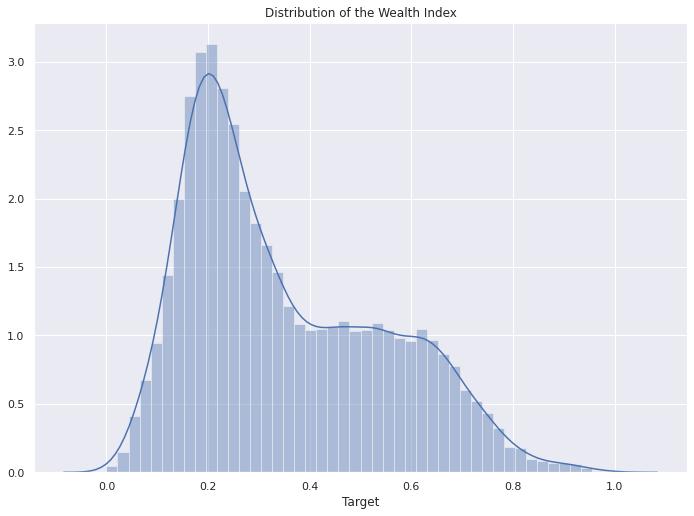

In [4]:
sns.distplot(wealth["Target"]).set(title="Distribution of the Wealth Index")

The distribution is not normal because it is skewed to the left. Therefore, putting this into consideration, we will need to explore a non parametric test for statistical analysis. We also need to keep in mind that the machine learning models to be used, should be those that do not assume normality of data.

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (All African Regions)')]

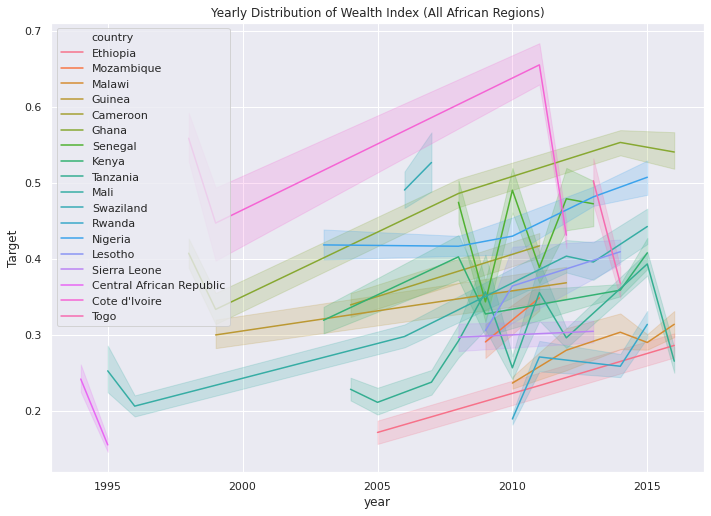

In [5]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth
).set(
    title="Yearly Distribution of Wealth Index (All African Regions)"
)

Looks a little shabby. Let's create African regions for a cleaner view.

In [6]:
# get countries of the different African regions
western = [
    "Benin", "Burkina Faso", "Cape" "Verde", "Côte D'Ivoire", "Gambia", "Ghana", "Guinea", 
    "Guinea-Bissau", "Liberia", "Mali", "Mauritania", "Niger", "Nigeria", "Senegal", "Sierra Leone", "Togo"
]

eastern = [
    "Burundi", "Comoros", "Djibouti", "Eritrea", "Ethiopia", "Kenya", "Madagascar", "Malawi", 
    "Mauritius", "Réunion", "Rwanda", "Seychelles", "Somalia", "Somaliland", "Tanzania", "Uganda"
]

central = [
    "Cameroon", "Central African Republic", "Chad", "Congo Republic - Brazzaville", 
    "Democratic Republic of Congo", "Equatorial Guinea", "Gabon", "São Tomé", "Principe"
]

southern = [
    "Angola", "Botswana", "Lesotho", "Mozambique", "Namibia", "South Africa", "Swaziland", 
    "Zambia", "Zimbabwe"
]

northern = [
    "Algeria", "Egypt", "Libya", "Morocco", "Sudan", "Tunisia", "Western Sahara"
]

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (Western Africa)')]

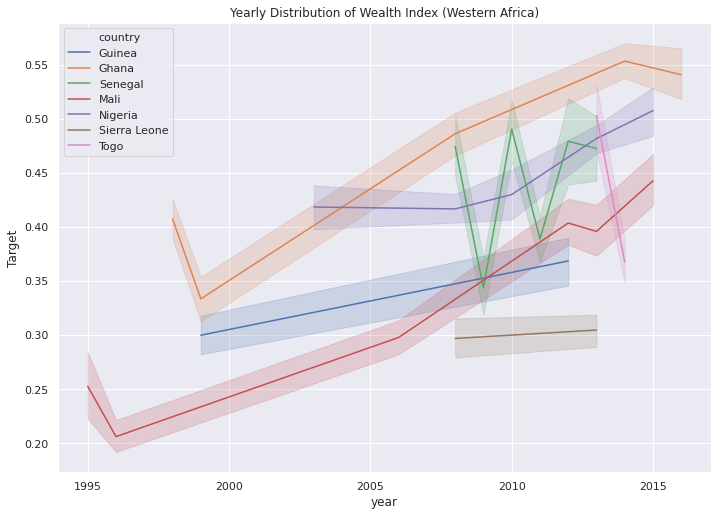

In [7]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(western)]
).set(
    title=("Yearly Distribution of Wealth Index (Western Africa)")
)

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (Eastern Africa)')]

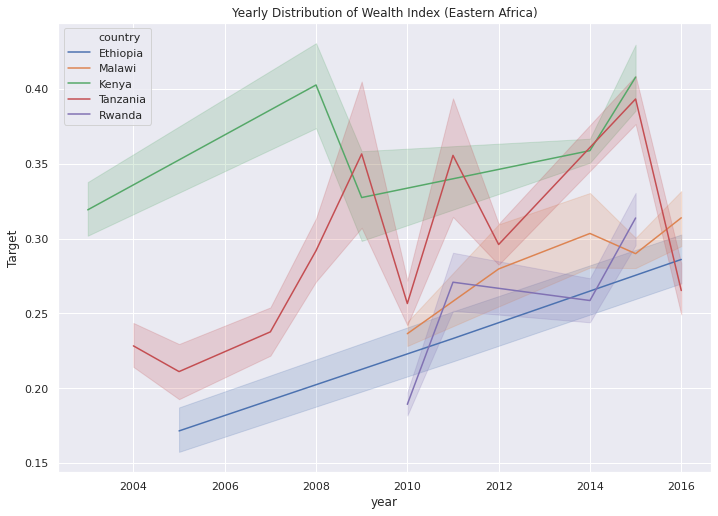

In [8]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(eastern)]
).set(
    title="Yearly Distribution of Wealth Index (Eastern Africa)"
)

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (Southern Africa)')]

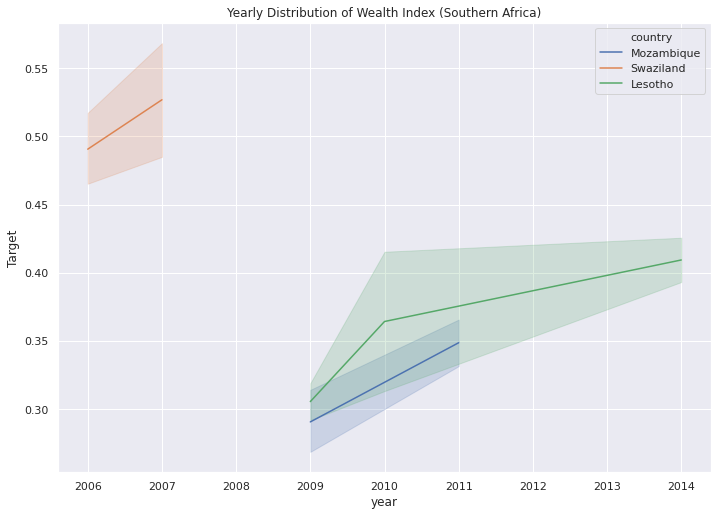

In [9]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(southern)]
).set(
    title="Yearly Distribution of Wealth Index (Southern Africa)"
)

[Text(0.5, 1.0, 'Yearly Distribution of Wealth Index (Central Africa)')]

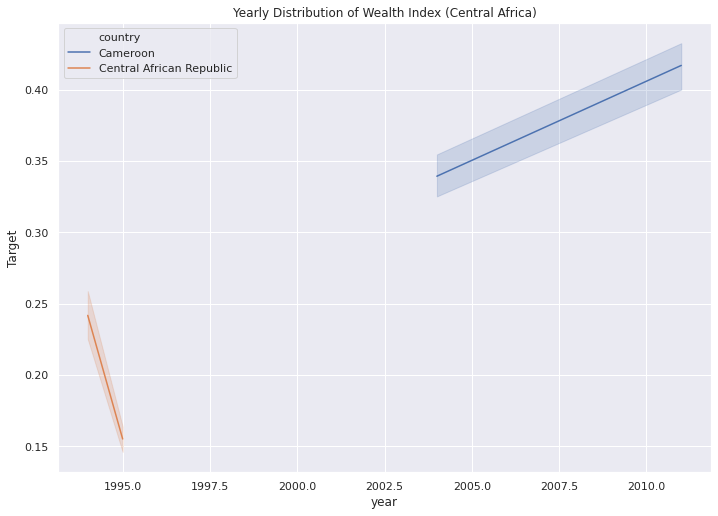

In [10]:
sns.lineplot(
    x="year", 
    y="Target", 
    hue="country", 
    data=wealth[wealth["country"].isin(central)]
).set(
    title="Yearly Distribution of Wealth Index (Central Africa)"
)

Based the above visualizations:
* **Western African Region**<br>
Most of the countries have an increase in wealth distribution. For Senegal, it has been experiencing some level of inconsistencies. This could be impacted by certain factors within the country.
---
* **Eastern African Region**<br>
Ethiopia is the only country experiencing a positive trend. The other countries in Eastern Africa seem to be having upwards and downwards trends. 
---
* **Central African Region**<br>
Not enough data has been captured for countries in this region. If anything, the Central African Republic experience a negative trend between the years before 1995.
---
* **Southern African Region**<br>
There is an increase in wealth distribution across the countries in the Southern African Regions.

[Text(0.5, 1.0, 'Wealth Distribution across Urban and Rural areas')]

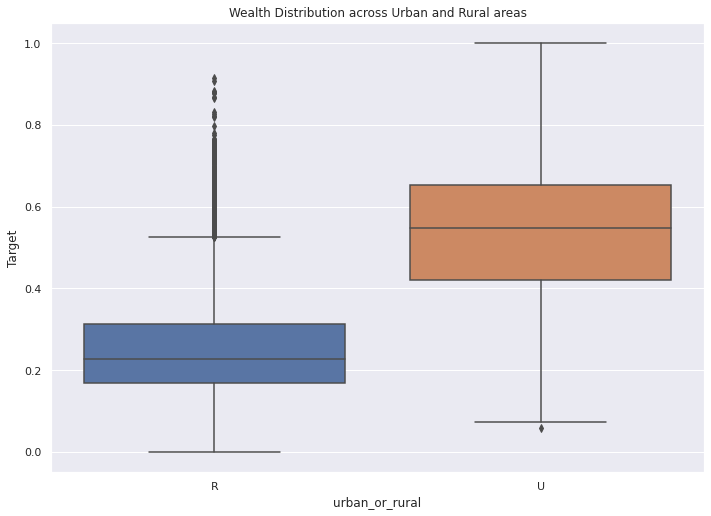

In [11]:
sns.boxplot(
    x="urban_or_rural", 
    y="Target", 
    data=wealth
).set(
    title="Wealth Distribution across Urban and Rural areas"
)

- Data from the rural areas has evident outliers while the urban data is consistent.
- People from urban areas are more wealthy from those from the rural areas.

[Text(0.5, 1.0, 'Wealth Distribution across the years (1990-1999)')]

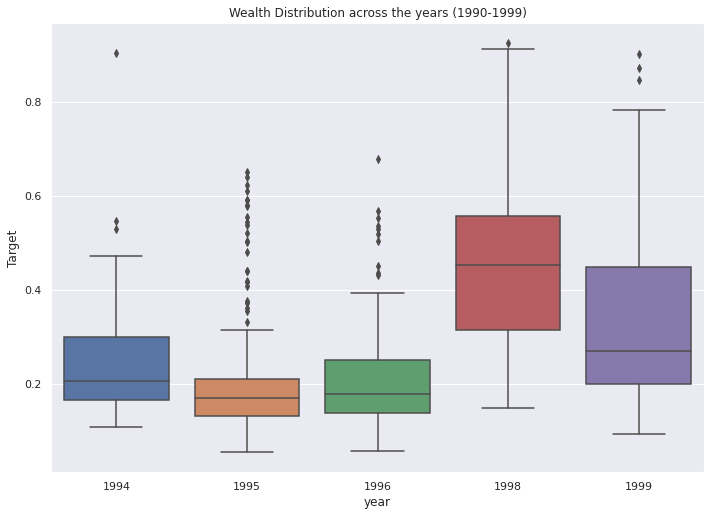

In [12]:
sns.boxplot(
    x="year", 
    y="Target", 
    data=wealth[wealth["year"] < 2000]
).set(
    title="Wealth Distribution across the years (1990-1999)"
)

* There was an increase in the wealth distribution in 1998. What happened in 1998?
* In 1995 and 1996, there are significant outliers.

[Text(0.5, 1.0, 'Wealth Distribution across the years (2000-2009)')]

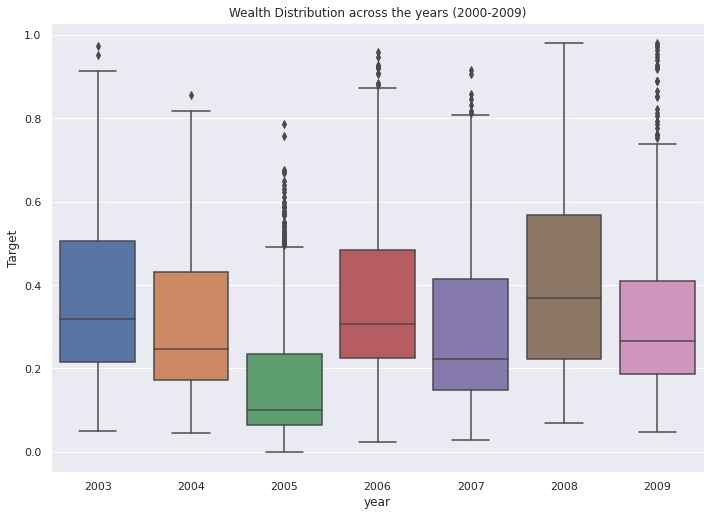

In [13]:
sns.boxplot(
    x="year", 
    y="Target", 
    data=wealth[(wealth["year"] > 1999) & (wealth["year"] < 2010)]
).set(
    title="Wealth Distribution across the years (2000-2009)"
)

* There is a dip in the wealth distribution in 2005 across the different countries.
* 2008 had the highest wealth distribution.
* There are also a couple of outliers

[Text(0.5, 1.0, 'Wealth Distribution across the years (2010-2019)')]

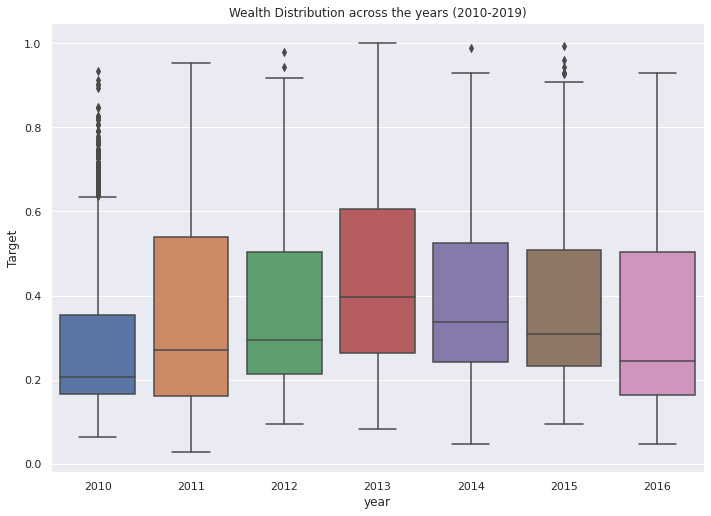

In [14]:
sns.boxplot(
    x="year", 
    y="Target", 
    data=wealth[wealth["year"] > 2009]
).set(
    title="Wealth Distribution across the years (2010-2019)"
)

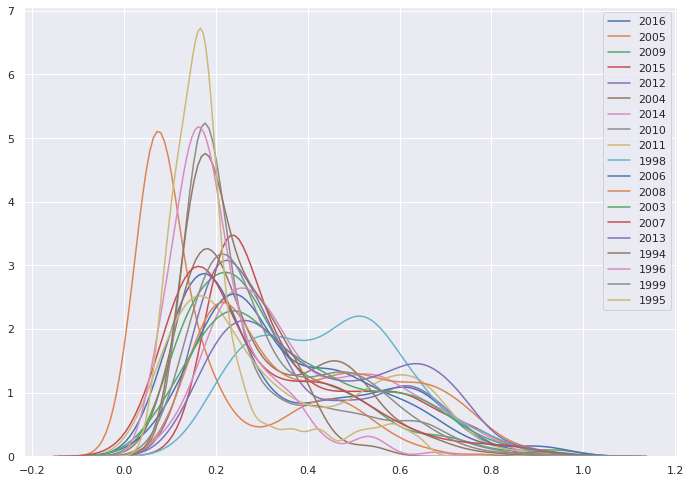

In [15]:
years = wealth["year"].unique()

for year in years:
    subset = wealth[wealth["year"] == year]
    sns.kdeplot(data=subset["Target"], label=year)

The other columns are numerical. That being said, the next step is to check the relationship between those columns with the wealth index and identifiy whether there is any correlation.

[Text(0.5, 1.0, 'ghsl water surface Relationship with Wealth')]

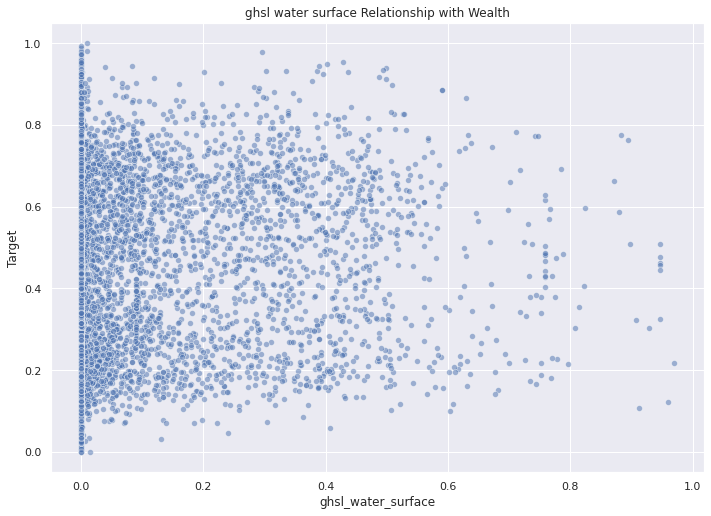

In [16]:
sns.scatterplot(
    x="ghsl_water_surface", 
    y="Target", 
    alpha=.5, 
    data=wealth
).set(
    title="ghsl water surface Relationship with Wealth"
)

Higher fraction of land within 5km of the cluster that is classified as water surface is wealthier.

[Text(0.5, 1.0, 'nighttime lights Relationship with Wealth')]

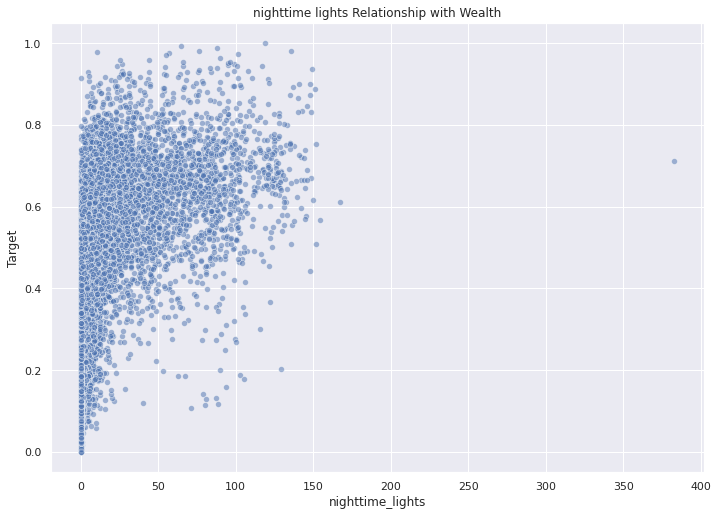

In [17]:
sns.scatterplot(
    x="nighttime_lights", 
    y="Target", 
    alpha=.5, 
    data=wealth
).set(
    title="nighttime lights Relationship with Wealth"
)

Countries with more nighttime lights are wealthier

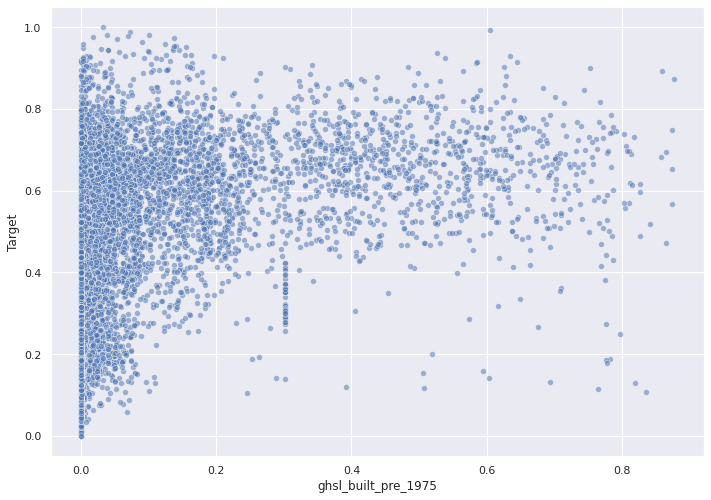

In [18]:
sns.scatterplot(x="ghsl_built_pre_1975", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up before 1975 are wealthier.

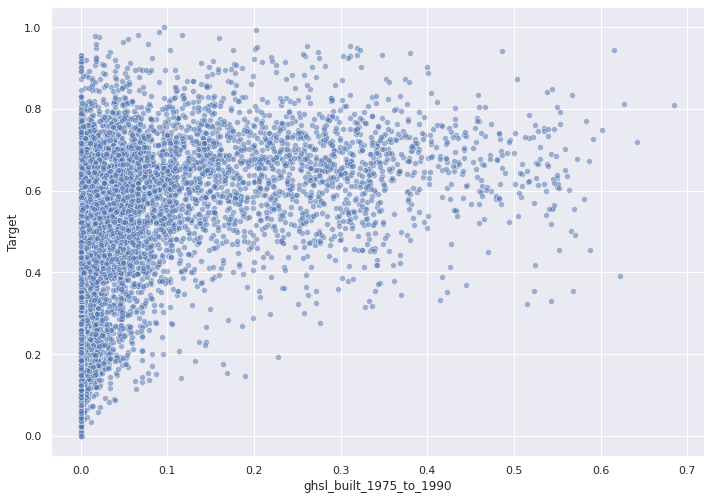

In [19]:
sns.scatterplot(x="ghsl_built_1975_to_1990", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 1975 to 1990 are wealthier.

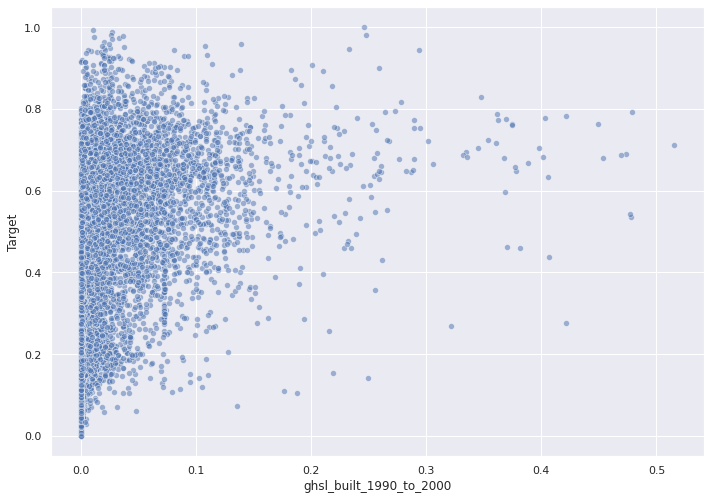

In [20]:
sns.scatterplot(x="ghsl_built_1990_to_2000", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 1990 to 2000 are wealthier.

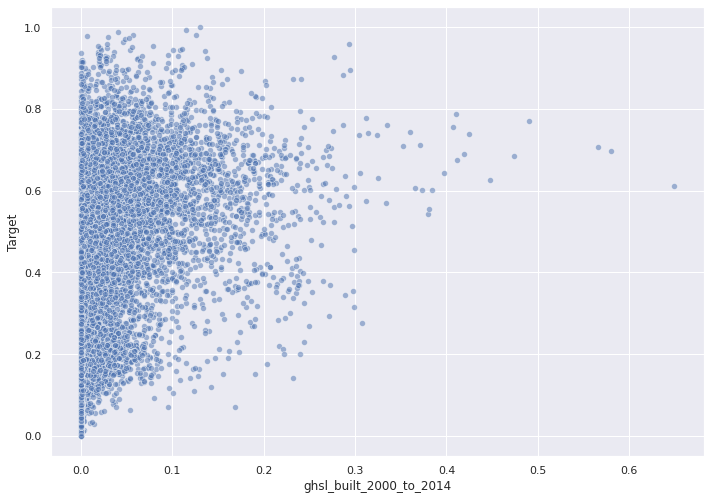

In [21]:
sns.scatterplot(x="ghsl_built_2000_to_2014", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as built-up between 2000 to 2014 are wealthier.

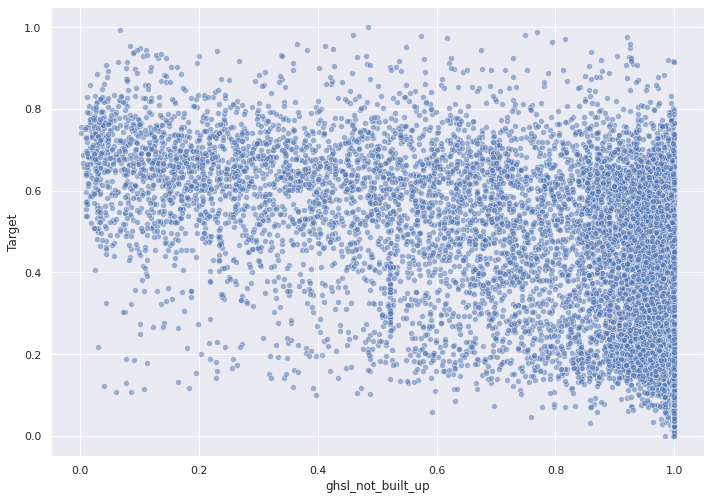

In [22]:
sns.scatterplot(x="ghsl_not_built_up", y="Target", alpha=.5, data=wealth)

The more the country has land that was never built up, the less wealthy they are.

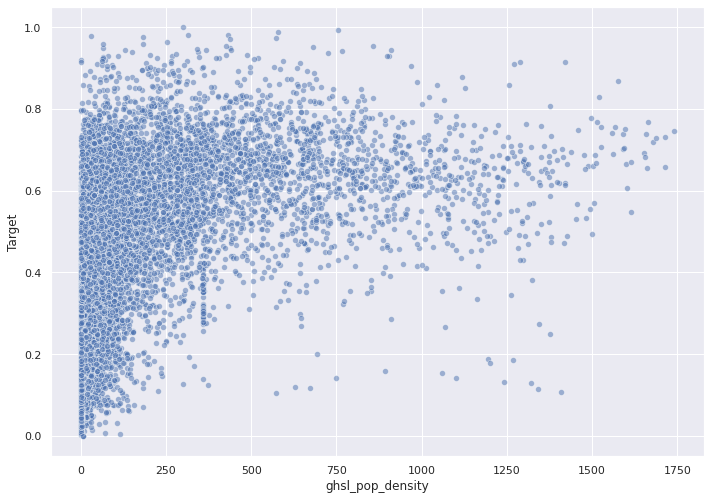

In [23]:
sns.scatterplot(x="ghsl_pop_density", y="Target", alpha=.5, data=wealth)

The higher the population density for the surrounding area is, the more wealthy the country is

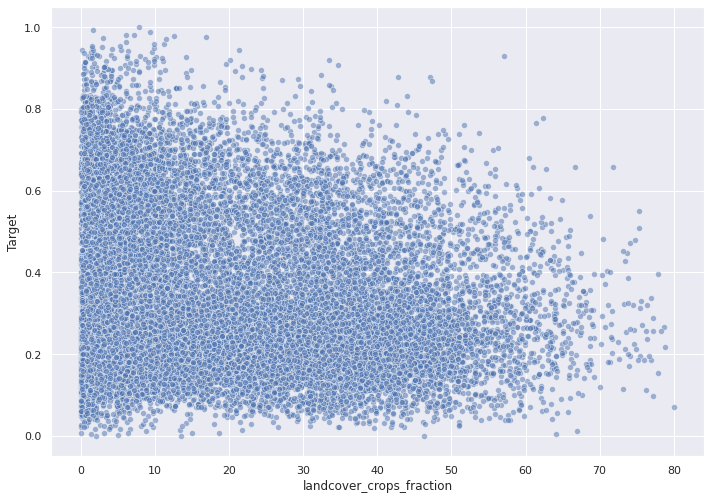

In [24]:
sns.scatterplot(x="landcover_crops_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as cropland are wealthier

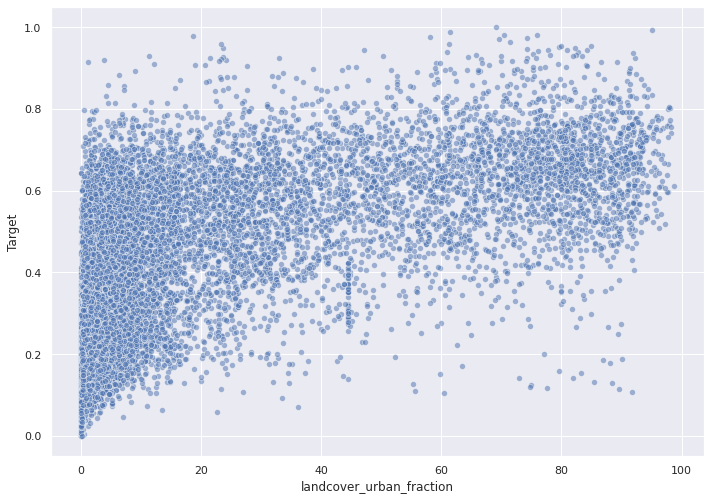

In [25]:
sns.scatterplot(x="landcover_urban_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 5km of the cluster that is classified as urban are wealthier.

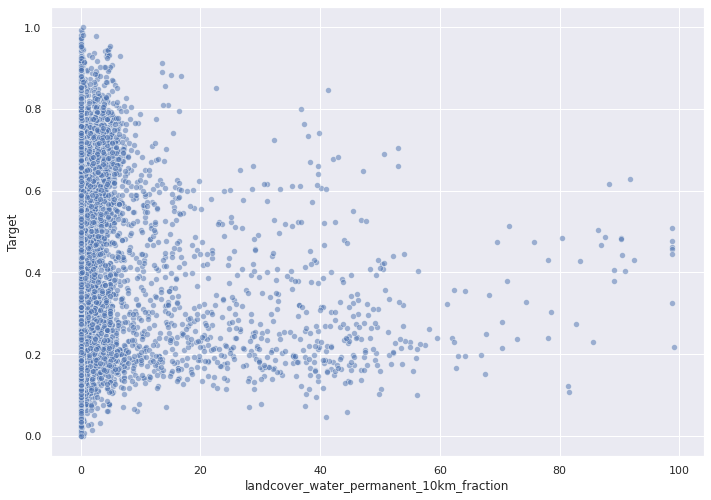

In [26]:
sns.scatterplot(x="landcover_water_permanent_10km_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 10km of the cluster that is classified as permanent water are wealthier.

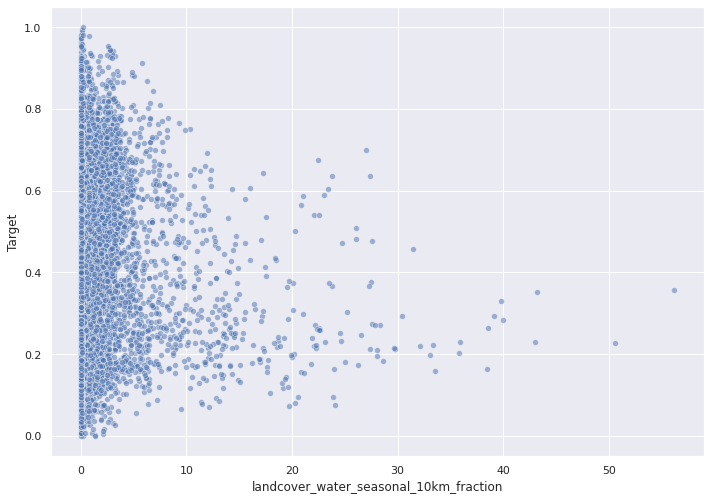

In [27]:
sns.scatterplot(x="landcover_water_seasonal_10km_fraction", y="Target", alpha=.5, data=wealth)

Higher fraction of land within 10km of the cluster that is classified as seasonal water are wealthier

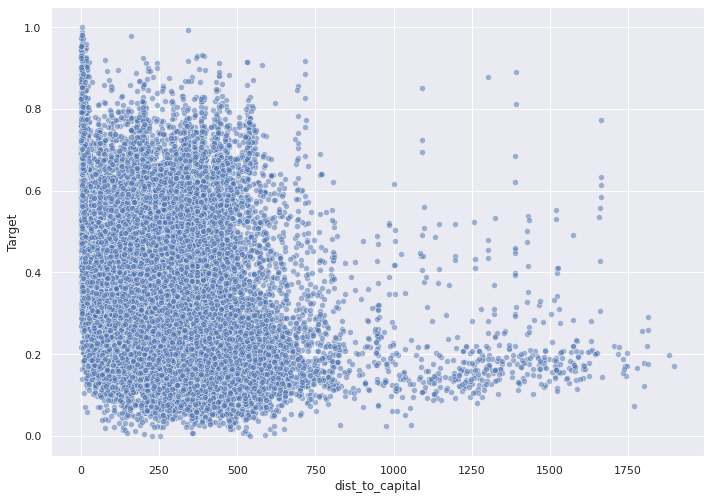

In [28]:
sns.scatterplot(x="dist_to_capital", y="Target", alpha=.5, data=wealth)

Higher distance to the countries capital are less wealthy.

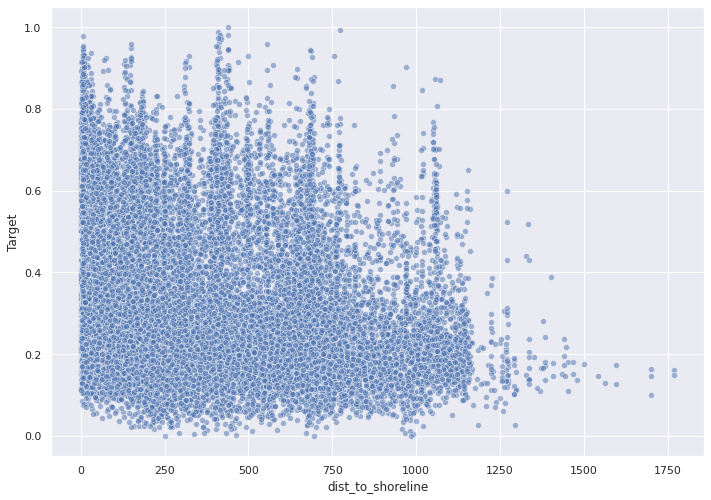

In [29]:
sns.scatterplot(x="dist_to_shoreline", y="Target", alpha=.5, data=wealth)

Higher distance to the nearest ocean shoreline are less wealthy.

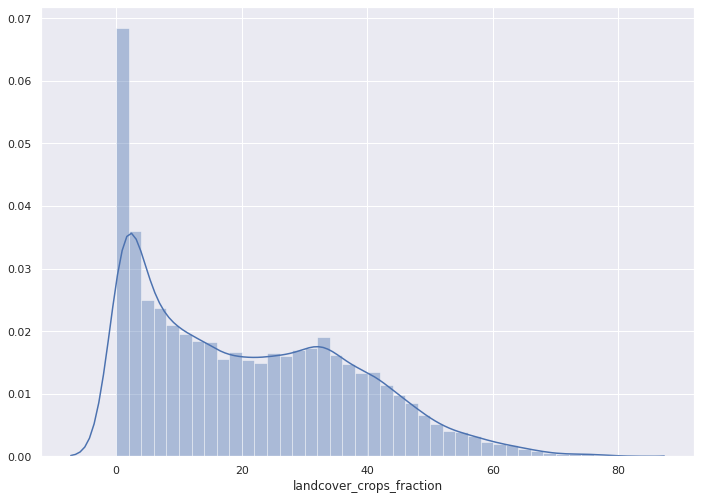

In [30]:
sns.distplot(wealth["landcover_crops_fraction"])

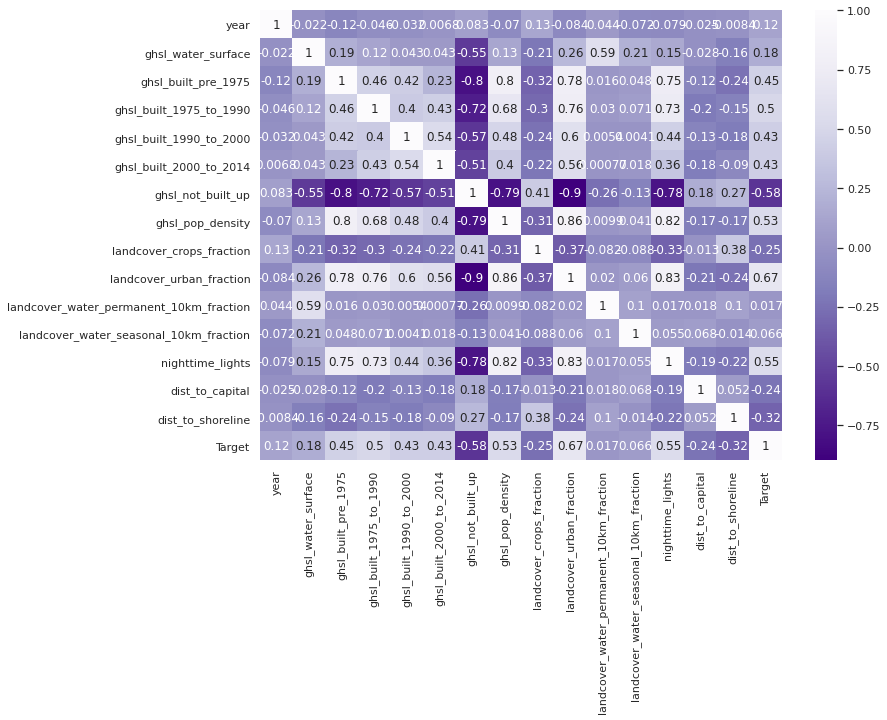

In [31]:
sns.heatmap(wealth.corr(), cbar=True, annot=True, cmap="Purples_r")

In [32]:
wealth["Target"].corr(wealth["year"])

0.11501431032367716

Positive correlation:
* Year<br>
    Target,<br>
    ghsl_water_surface, <br>
    ghsl_built_pre_1975, <br>
    ghsl_built_1975_to_1990, <br>
    ghsl_built_1990_to_2000, <br>
    ghsl_built_2000_to_2014, <br>
    ghsl_pop_density, <br>
    landcover_urban_fraction, <br>
    landcover_water_permanent_10km_fraction, <br>
    landcover_water_seasonal_10km_fraction, <br>
    nighttime_lights

Negative correlation:
* Year <br>
    ghsl_not_built_up, <br>
    landcover_crops_fraction, <br>
    dist_to_capital, <br>
    dist_to_shoreline

## Machine Learning
---

In [98]:
features = wealth.drop(columns=["ID", "country", "year", "urban_or_rural", "Target"])
target = pd.DataFrame(wealth["Target"])

X, X_test, y, y_test = train_test_split(features, target, test_size=0.20)

In [34]:
# X.score()

In [35]:
print("Predictor Train Features: {}".format(features.shape))
print("Predictor Test Features: {}".format(wealthTest.shape))
print("Target Train Features: {}".format(target.shape))
# print("Target Test Features: {}".format(y_test.shape))

Predictor Train Features: (21454, 14)
Predictor Test Features: (7194, 18)
Target Train Features: (21454, 1)


In [36]:
rf = RandomForestRegressor()
cb = CatBoostRegressor()
lgbm = LGBMRegressor()

In [37]:
# rf.fit(features, target.values.ravel())

RandomForestRegressor()

In [38]:
# rf.predict(wealthTest[features.columns])

array([0.20863451, 0.17112178, 0.60679808, ..., 0.37666279, 0.16548676,
       0.34389026])

In [99]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def training_and_evaluate(model):
    model.fit(X, y.values.ravel())
    print("{}".format(model))
    print("-"*30+ "\n")
    print("Training accuracy: {}".format(model.score(X, y)))
    print("Testing accuracy: {}".format(model.score(X_test, y_test)))
    
    model_pred = model.predict(X_test)
    
    model_mae = mae(y_test["Target"], model_pred)
    
    print("Mean Absolute Error: {}\n\n".format(model_mae))
    
    return model_mae

In [100]:
rfMae = training_and_evaluate(rf)
lgbmMae = training_and_evaluate(lgbm)

RandomForestRegressor()
------------------------------

Training accuracy: 0.9561607525899282
Testing accuracy: 0.7048483411381707
Mean Absolute Error: 0.07852721153442746


LGBMRegressor()
------------------------------

Training accuracy: 0.760769678173967
Testing accuracy: 0.7086554146459871
Mean Absolute Error: 0.07902419099917364




Better marginal difference between the training accuracy and the test accuracy. Adjusting the training data from 0.3 to 0.2 has reduced overfitting for the lgbm. It has caused a change in the random forest model, however there is still overfitting detected. 

In [41]:
submission["Target"] = rf.predict(wealthTest[features.columns])
submission.head()

ID    Target
0  ID_AAcismbB  0.239431
1  ID_AAeBMsji  0.164172
2  ID_AAjFMjzy  0.617443
3  ID_AAmMOEEC  0.278274
4  ID_ABguzDxp  0.272220

In [42]:
# submission.to_csv("Test_Submission.csv", index=False)

### Hyperparameter Tuning
#### Random Search with Cross Validation

In [43]:
# current parameters in the random forest regressor
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Important parameters for the tuning:
- n_estimators
- max_features
- max_depth
- min_samples_split
- min_samples_leaf
- bootsrap

In [44]:
n_estimators = [200, 1000, 2000]
max_features = ["auto", "sqrt", "log2"]
max_depth = [40, 50, 60]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [40, 50, 60, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 2000]}


In [45]:
rf_improved = RandomizedSearchCV(estimator=rf, 
                                 param_distributions=random_grid, 
                                 n_iter=10, 
                                 cv=3, 
                                 verbose=2, 
                                 random_state=42, 
                                 n_jobs=-1)

rf_improved.fit(features, target.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [40, 50, 60, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 1000, 2000]},
                   random_state=42, verbose=2)

In [46]:
rf_improved.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [47]:
rfImprovedMae = training_and_evaluate(rf_improved.best_estimator_)
print("Hyperparameter Tuned (Random Search) Mean Absolute Error: {}".format(rfImprovedMae))

Hyperparameter Tuned (Random Search) Mean Absolute Error: 0.04583459270139278


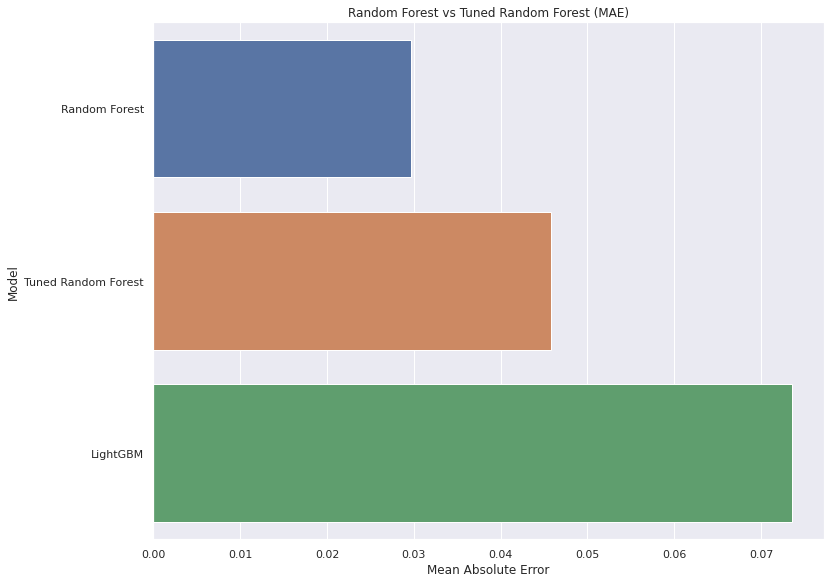

In [66]:
modelComparison = pd.DataFrame({"model": ["Random Forest",
                                          "LightGBM",
                                          "Tuned Random Forest"], 
                                "mae": [rfMae, lgbmMae, rfImprovedMae]})

sns.barplot(y="model", 
            x="mae", 
            data=modelComparison.sort_values(["mae"])).set(title="Random Forest vs Tuned Random Forest (MAE)", 
                                      ylabel="Model", 
                                      xlabel="Mean Absolute Error")

plt.tight_layout()

The tuned random forest does not show an improved model performance. Therefore, I shall explore another machine learning and check performance against the above.

In [ ]:
submission["Target"] = rf_improved.best_estimator_.predict(wealthTest[features.columns])
submission.head()

In [ ]:
# submission.to_csv("Final_Submission.csv", index=False)

#### Grid Search with Cross Validation

In [ ]:
# param_grid = {
#     "n_estimators": [1000, 2000],
#     "max_features": [2, 3],
#     "max_depth": [50, 70, 90, 100], 
#     "min_samples_split": [2, 8, 10],
#     "min_samples_leaf": [3, 4, 5],
    
# }

In [ ]:
# gridSearch = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1,
#     verbose=5,
# )

In [ ]:
# gridSearch.fit(features, target)

In [ ]:
# gridSearch.best_params_

In [ ]:
# rfImprovedMae_ = training_and_evaluate(gridSearch.best_estimator_)
# print("Hyperparameter Tuned (Random Search) Mean Absolute Error: {}".format(rfImprovedMae_))

In [49]:
# lgbm.fit(features, target.values.ravel())

LGBMRegressor()

In [67]:
(pprint(lgbm.get_params()))

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}
